# Code Demo For Analysis of Pseudo Gradient Descent
This file shows the basic implementation of the following experiment:
* visualize the pseudo gradient descent of both thinking and nothinking modes
* analysis the role of reflection token or nothinking token delimiter

In [25]:
import os
from collections import defaultdict
import random
random.seed(42)

from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

### Preparation

load tokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/QwQ-32B")

load AIME24 data

In [3]:
dataset = load_dataset("HuggingFaceH4/aime_2024", split="train")

load model

In [ ]:
model = LLM("Qwen/QwQ-32B", tensor_parallel_size=2, gpu_memory_utilization=0.8)

### Rollout Under Thinking/NoThinking Mode

define verify function

In [5]:
def score(predictions, references):
    try:
        from latex2sympy2_extended import NormalizationConfig
        from math_verify import (ExprExtractionConfig,
                                    LatexExtractionConfig, parse, verify)
    except ImportError:
        raise ImportError('Failed to import required modules. Please '
                            'install the necessary packages: '
                            'pip install math_verify latex2sympy2_extended')

    correct = 0
    count = 0
    details = []
    for i, j in zip(predictions, references):
        count += 1
        j_with_env = f'${j}$'
        gold_parsed = parse(
            j_with_env,
            extraction_mode='first_match',
            extraction_config=[
                LatexExtractionConfig(),
                ExprExtractionConfig(),
            ],
        )

        if len(gold_parsed) != 0:
            # We require the answer to be provided in correct
            # latex (no malformed operators)
            answer_parsed = parse(
                i,
                extraction_config=[
                    LatexExtractionConfig(
                        normalization_config=NormalizationConfig(
                            nits=False,
                            malformed_operators=False,
                            basic_latex=True,
                            equations=True,
                            boxed='all',
                            units=True,
                        ),
                        # Ensures that boxed is tried first
                        boxed_match_priority=0,
                        try_extract_without_anchor=False,
                    )
                ],
                extraction_mode='first_match',
            )

            answer_correct = float(verify(answer_parsed, gold_parsed))
            correct += answer_correct
            detail = {
                'pred': str(answer_parsed),
                'answer': str(gold_parsed),
                'correct': True if answer_correct else False,
            }
            details.append(detail)
    return details


construct prompts

In [6]:
prompt_template = "{question}\n\nPlease reason step by step, and put your final answer within \\boxed{{}}"
inputs = []
answers = []
questions = []
for example in dataset:
    questions.append(example["problem"])
    messages = [
        {"role": "user", "content": prompt_template.format(question=questions[-1])}
    ]
    inputs.append(tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=True))
    # nothinking: tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=True) +  + "Therefore, after all this, I believe the answer is"
    # or qwen3: tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)
    answers.append(example["answer"])

generate response, only one sample for simple demo

In [7]:
sampling_params = SamplingParams(
    max_tokens=32768,  
    temperature=0.6,  
    top_p=0.95,
    min_p=0.0,
    top_k=40,
    n=16,
    skip_special_tokens=False,
)
thinking_outputs = model.generate(inputs[:1], sampling_params, use_tqdm=True)

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts: 100%|██████████| 16/16 [02:11<00:00,  8.24s/it, est. speed input: 19.17 toks/s, output: 405.62 toks/s]


parse and evaluate the trajectories

In [8]:
thinking_trajectories = []
references = []
for output, answer in zip(thinking_outputs, answers[:1]):
    prompt = output.prompt
    for r in output.outputs:
        thinking_trajectories.append(r.text)
        references.append(answer)
thinking_scores = score(thinking_trajectories, references)

[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it handled by the parser now
[2025-05-25 17:41:36] WARNING math_normalization.py:466: equations is deprecated, as it 

compute plausibility of the answer at each position ($\mathcal{\hat{L}}$) of sampled correct reasoning trajectory

In [9]:
messages = [
    {"role": "user", "content": prompt_template.format(question=questions[0])}
]
input_prefix = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=True)
answer_tokens = tokenizer.encode("\n\n**Final Answer**\n\\boxed{" + answers[0], add_special_tokens=False)
thinking_prompt2logprobs = {
    "question": questions[0], 
    "answer": answers[0],
    'logprobs': []
}
for trajectory in random.sample([trajectory for trajectory, score in zip(thinking_trajectories, thinking_scores) if score["correct"]], k=1):
    input_and_response = input_prefix + trajectory
    tokens = tokenizer.encode(input_and_response, add_special_tokens=False)
    think_token_ids = tokenizer.encode("<think>", add_special_tokens=False)

    def find_subsequence(tokens, sub):
        for i in range(len(tokens) - len(sub) + 1):
            if tokens[i:i+len(sub)] == sub:
                return i
        return -1
    think_pos = find_subsequence(tokens, think_token_ids)
    assert think_pos != -1

    prefixes = []
    for end in range(think_pos + 1, len(tokens) + 1):
        prefixes.append(tokens[:end] + answer_tokens)

    sampling_params = SamplingParams(
        temperature=0, prompt_logprobs=1, max_tokens=1
    )
    outputs = model.generate([
        {"prompt_token_ids": prefix} for prefix in prefixes
    ], sampling_params, use_tqdm=True)
    thinking_prompt2logprobs["logprobs"].append([])
    for i, (output, prefix) in enumerate(zip(outputs, prefixes)):
        def extract_logprobs(logprobs, tokens):
            probs = []
            for item, tok_id in zip(logprobs, tokens):
                probs.append(item[tok_id].logprob) if item is not None else probs.append(None)
            return probs
        thinking_prompt2logprobs["logprobs"][-1].append({
            "prompt_ids": prefix,
            "logprobs": extract_logprobs(output.prompt_logprobs, prefix)
        })

Processed prompts: 100%|██████████| 3429/3429 [18:14<00:00,  3.13it/s, est. speed input: 5894.91 toks/s, output: 3.13 toks/s]


### Visualization of Pseudo Gradient Descent

extract $\mathcal{\hat{L}}$

In [10]:
thinking_L = {
    "question": thinking_prompt2logprobs["question"],
    "answer": thinking_prompt2logprobs["answer"],
    "logprobs": []
}
answer_tokens = tokenizer.encode(thinking_prompt2logprobs["answer"], add_special_tokens=False)
extended_answer_tokens = tokenizer.encode("\n\n**Final Answer**\n\\boxed{" + thinking_prompt2logprobs["answer"], add_special_tokens=False)
for item in thinking_prompt2logprobs["logprobs"][0]:
    thinking_L["logprobs"].append(-np.mean(item["logprobs"][-len(answer_tokens):]))
thinking_L["logprobs"] = thinking_L["logprobs"][:-len(extended_answer_tokens)]

draw the curve of $\mathcal{\hat{L}}$

[2025-05-25 18:10:38] INFO _mathtext.py:648: Substituting symbol L from STIXNonUnicode


[2025-05-25 18:10:38] INFO _mathtext.py:648: Substituting symbol L from STIXNonUnicode


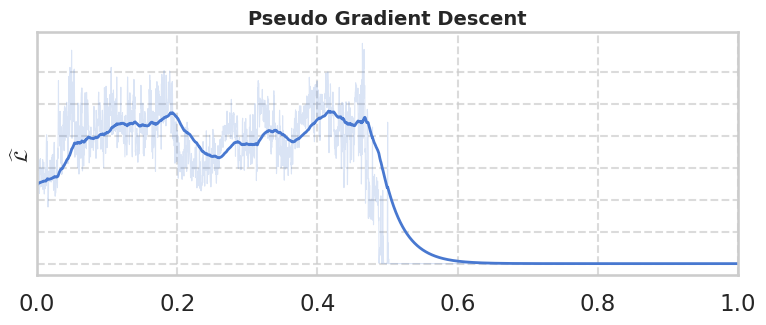

In [11]:
plt.rcParams['font.family'] = 'Maple Mono'
plt.rcParams['font.weight'] = 'normal'

sns.set_theme(style="whitegrid")
sns.set_context("talk")

fig = plt.figure(figsize=(8, 4))

linestyles = ['-', '--', '-.', ':']

legend_handles = []
legend_labels = []

logprobs = thinking_L['logprobs']
    
colors = sns.color_palette("muted")
    
raw_data = np.array(logprobs)
raw_data = raw_data[raw_data != 0.0]

indices = np.arange(0, len(raw_data))
normalized_indices = indices / (len(indices) - 1) if len(indices) > 1 else indices

color_idx = random.randint(0, 4)
colors = sns.color_palette("muted")

plt.plot(normalized_indices, raw_data, 
        color=colors[color_idx], 
        alpha=0.2,
        linewidth=0.8)

alpha = 0.01  
smooth_data = np.zeros_like(raw_data)
smooth_data[0] = raw_data[0]

for t in range(1, len(raw_data)):
    smooth_data[t] = alpha * raw_data[t] + (1 - alpha) * smooth_data[t-1]
    
smooth_line = plt.plot(normalized_indices, smooth_data, 
        color=colors[color_idx], 
        linewidth=2)
    
plt.xlabel('') 
plt.title("Pseudo Gradient Descent", fontdict={"size": 14, "weight": "bold"})
plt.grid(True, linestyle='--', alpha=0.7)
    
plt.xlim(0, 1)
    
plt.ylabel('$\mathcal{\widehat{L}}$', fontdict={"size": 14, "weight": "bold"})
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.yticks([0,1,2,3,4,5,6],[0,1,2,3,4,5,6])


plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


### Analysis of the Reflection Tokens in the Pseudo Gradient Descent

In [28]:
reflection_pattern_words = [
    r"wait",
    r"Wait",
    r"retry",
    r"Retry",
    r"recheck",
    r"Recheck",
    r"however",
    r"However",
    r"alternatively",
    r"Alternatively",
]
reflection_token_ids = []
for word in reflection_pattern_words:
    token_ids = tokenizer.encode(word, add_special_tokens=False)
    reflection_token_ids.append(token_ids)

answer_tokens = tokenizer.encode(thinking_prompt2logprobs["answer"], add_special_tokens=False)
extended_answer_tokens = tokenizer.encode("\n\n**Final Answer**\n\\boxed{" + thinking_prompt2logprobs["answer"], add_special_tokens=False)
all_logprobs = []
for item in thinking_prompt2logprobs["logprobs"][0]:
    if item["prompt_ids"][:-len(extended_answer_tokens)][-1] == tokenizer.encode("</think>", add_special_tokens=False)[0]:
        break
    all_logprobs.append((item["prompt_ids"][:-len(extended_answer_tokens)][-1], -np.mean(item["logprobs"][-len(answer_tokens):])))
all_logprobs = all_logprobs[:-len(extended_answer_tokens)]
    
reflection_changes = defaultdict(list)
all_token_changes = []

token_changes = defaultdict(list)

for i in range(1, len(all_logprobs)):
    prev_token_id, prev_logprob = all_logprobs[i-1]
    curr_token_id, curr_logprob = all_logprobs[i]
    
    if prev_logprob == 0:  
        continue
        
    relative_change = abs(curr_logprob - prev_logprob) / prev_logprob
    all_token_changes.append(relative_change)
    
    token_changes[curr_token_id].append(relative_change)
        
    for idx, reflection_ids in enumerate(reflection_token_ids):
        if len(reflection_ids) > 0 and curr_token_id == reflection_ids[0]:
            ii, jj = i, 0
            while jj < len(reflection_ids) and ii < len(all_logprobs):
                if all_logprobs[ii][0] != reflection_ids[jj]:
                    break
                ii += 1
                jj += 1

            if jj == len(reflection_ids):
                word = reflection_pattern_words[idx]
                reflection_changes[word].append(abs(all_logprobs[ii][1] - prev_logprob) / prev_logprob)
    
overall_avg_change = np.mean(all_token_changes)
overall_std_change = np.std(all_token_changes)

print(f"Overall delta: {overall_avg_change:.4f} ± {overall_std_change:.4f}")
print("\nReflection token delta:")
    
for word, changes in reflection_changes.items():
    if len(changes) > 0:
        avg_change = np.mean(changes)
        std_change = np.std(changes)
        diff_from_overall = avg_change - overall_avg_change
        print(f"'{word}': {avg_change:.4f} ± {std_change:.4f} (diff: {diff_from_overall:.4f})")
        print(f"  frequency: {len(changes)}")
    else:
        print(f"'{word}': Not found")

Overall delta: 0.7638 ± 14.1350

Reflection token delta:
'Wait': 1.2891 ± 2.4015 (diff: 0.5253)
  frequency: 10
'Alternatively': 0.5805 ± 0.6678 (diff: -0.1834)
  frequency: 8


: 